# Sentiment Analysis of Federal Reserves
### Meta Data Basic Analysis

Key economic indicators, including the Federal Funds Rate, Gross Domestic Product (GDP), Unemployment Rate, and Consumer Price Index (CPI), spanning from 1996 to 2023 on a monthly basis, were compiled to form a comprehensive dataset. These indices provide a multifaceted view of the economy's health and are instrumental in analyzing trends and forecasting future economic conditions. Due to limitations with the Nasdaq API (used by previous work \citep{fedspeak_nlp_pipeline}) post-2021, additional sources were utilized to ensure the dataset's continuity and completeness for subsequent analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
#nasdaqdatalink.api_key = 'M3geuff1prDgYkajPZNu'
#quandl.ApiConfig.api_key = 'M3geuff1prDgYkajPZNu'
# Web API
FRED_api = 'c4a3900347be8d17b1426b4536bcc12b'

In [3]:
# get current date in format YYYY-MM-DD
from datetime import datetime
current_date = datetime.now().strftime('%Y-%m-%d')
current_date

'2023-12-04'

In [4]:
# get real GDP data from FRED
base_url = 'https://api.stlouisfed.org/fred/series/observations?'

In [5]:
# Function to get quarterly data from FRED
def get_FRED_data(series_id, start_date = '1996-01-01', end_date = current_date, units = 'lin', fill_na = True):
    base_url = 'https://api.stlouisfed.org/fred/series/observations?'
    req = requests.get(
        base_url,
        params={
            'api_key': FRED_api,
            'series_id': series_id,
            'file_type': 'json',
            'observation_start': start_date,
            'observation_end': end_date,
            'units': units,
        }
    )
    data = req.json()
    data = pd.DataFrame(data['observations'])
    data.drop(columns = 'realtime_start', inplace = True)
    data.drop(columns = 'realtime_end', inplace = True)
    data['date'] = pd.to_datetime(data['date'])
    data.rename(columns={'value': series_id}, inplace=True)
    #data.set_index('date', inplace = True)
    if fill_na:
        data[series_id].ffill(inplace = True)
    return data

In [6]:
# Function to merge data by date
def merge_data(data_dict, series_id_list):
    data = data_dict[series_id_list[0]]
    # merge data
    for series_id in series_id_list[1:]:
        data = data.merge(data_dict[series_id], how = 'left', on = 'date')

    # convert data to float
    for series_id in series_id_list:
        data[series_id] = data[series_id].astype(float)
    return data

In [7]:
def get_data(data_unit, fill_na = True):
    series_id_list = ['FEDFUNDS', 'GDPC1', 'UNRATE', 'MEDCPIM158SFRBCLE', 'RSAFS', 'UMCSENT']
    series_dict = {}
    for series_id in series_id_list:
        series_dict[series_id] = get_FRED_data(series_id, units=data_unit)
    data = merge_data(series_dict, series_id_list)
    return data

In [8]:
lin_data = get_data('lin', fill_na = True) # linear data
percent_year = get_data('pc1', fill_na = True) # percent change from year ago
percent_month = get_data('pch', fill_na = True) # percent change from month ago

In [9]:
lin_data.head()

,date,FEDFUNDS,GDPC1,UNRATE,MEDCPIM158SFRBCLE,RSAFS,UMCSENT
0,1996-01-01,5.56,11614.418,5.6,3.775768,208699.0,89.3
1,1996-02-01,5.22,NaN,5.5,2.618961,212008.0,88.5
2,1996-03-01,5.31,NaN,5.5,3.110565,213891.0,93.7
3,1996-04-01,5.22,11808.140,5.6,3.133276,214676.0,92.7
4,1996-05-01,5.24,NaN,5.6,2.937790,216299.0,89.4


**From the dataframe we can see that since GDP data released quatarly, we have NaN value on the month without new data. In the following, I will use the ffil function from pandas to fill the NaN value, this method may introduce some bias.**

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data(data):
    series_id_dict = {'FEDFUNDS': 'Federal Funds Rate',
                  'GDPC1': 'Real GDP', 
                  'UNRATE': 'Unemployment Rate',
                  'MEDCPIM158SFRBCLE': 'Median CPI', 
                  'RSAFS': 'Advance Retail Sales: Retail Trade and food service', 
                  'UMCSENT': 'Consumer Sentiment',
                  }
    columns = data.columns
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    axs = axs.flatten()
    for i in range(1, len(columns)):
        axs[i-1].plot(data['date'], data[columns[i]])
        axs[i-1].set_title(series_id_dict[columns[i]])
    plt.tight_layout()
    plt.show()

**FEDFUNDS**: Federal Reserve Rate

**GPDC1**: Real GDP

**UNRATE**: Unemployment Rate

**MEDCPIM158SFRBCLE**: Median CPI

**RSAFS**:Advance Retail Sales: Retail Trade and food service

**UMCSENT**: Consumer Sentiment

**DPCCRV1Q225SBEA**: PCE Excluding Food and Energy

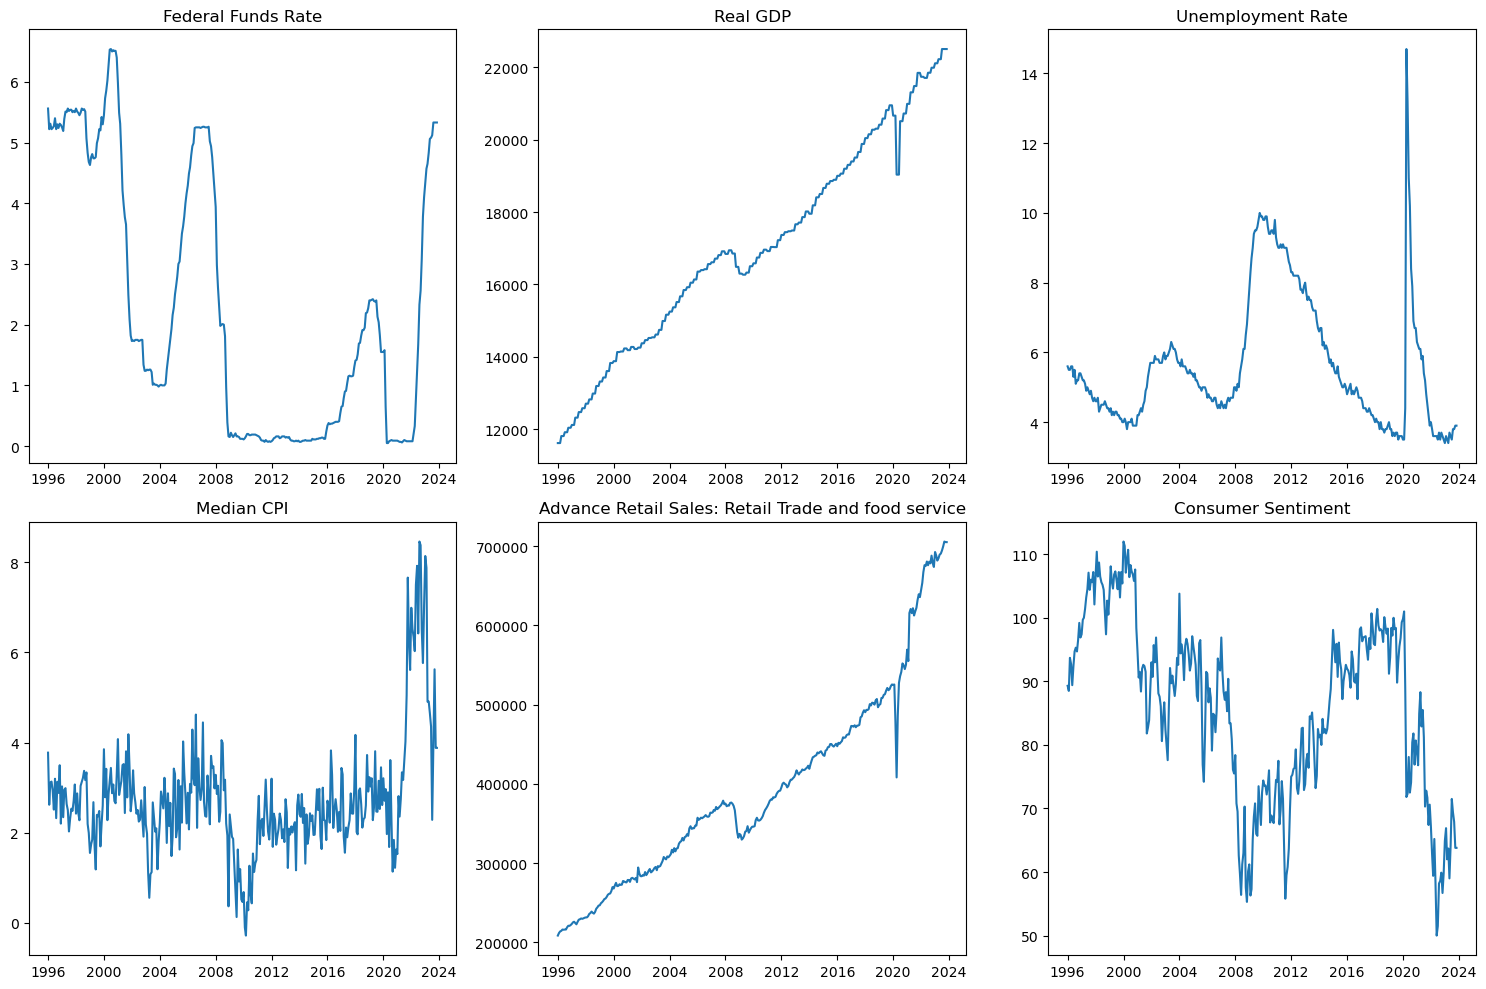

In [11]:
plot_data(lin_data.ffill())

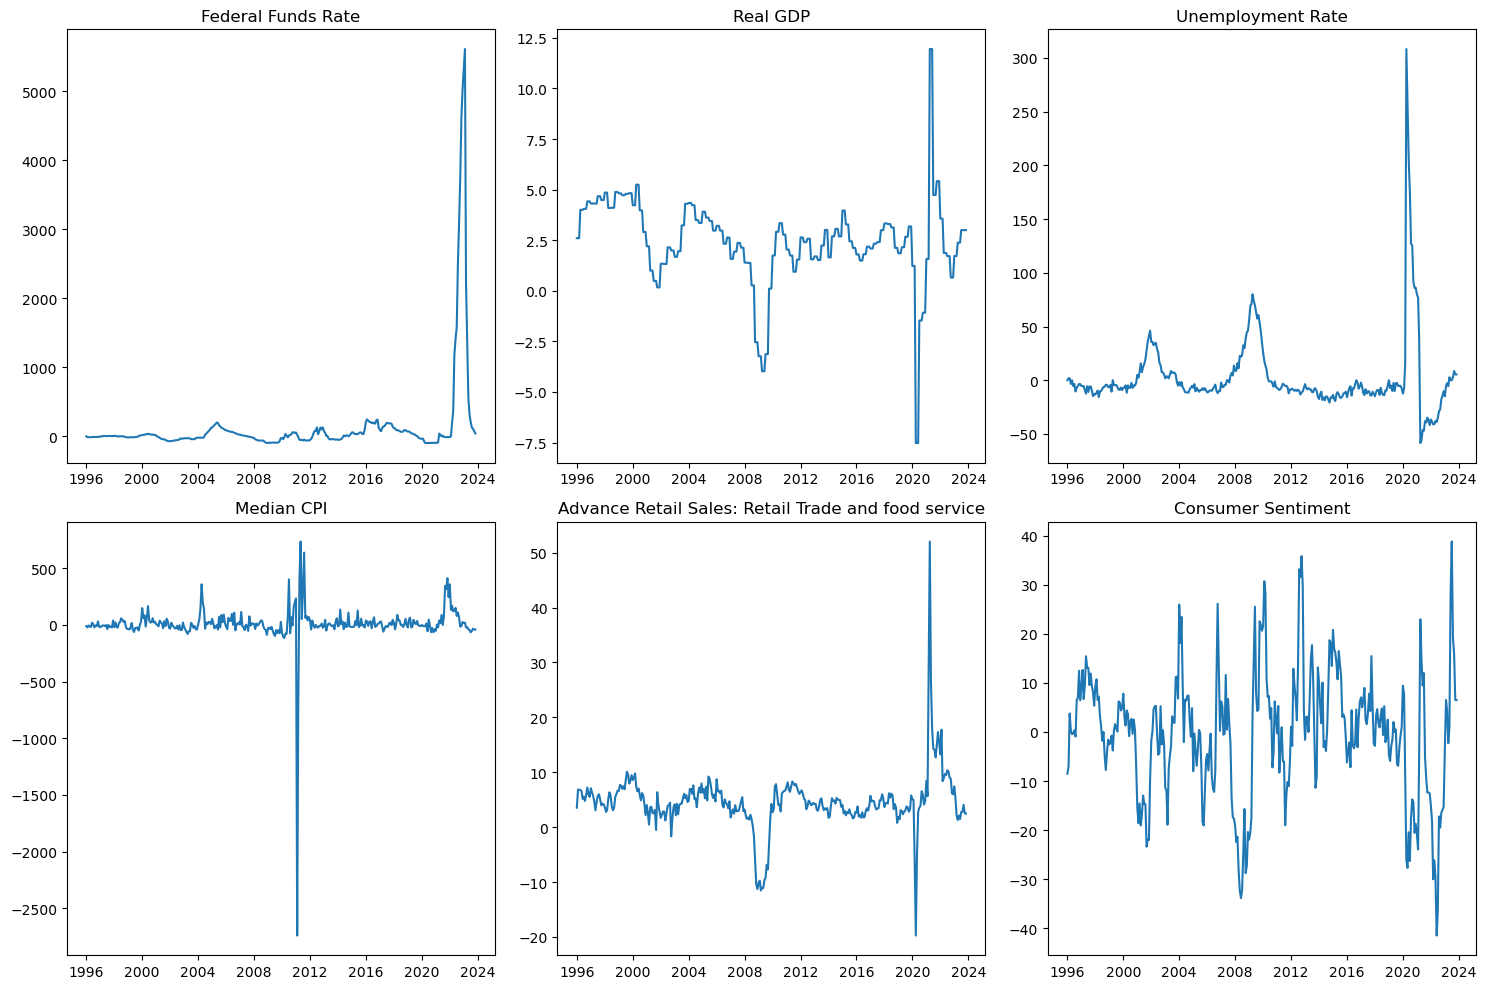

In [12]:
plot_data(percent_year.ffill())

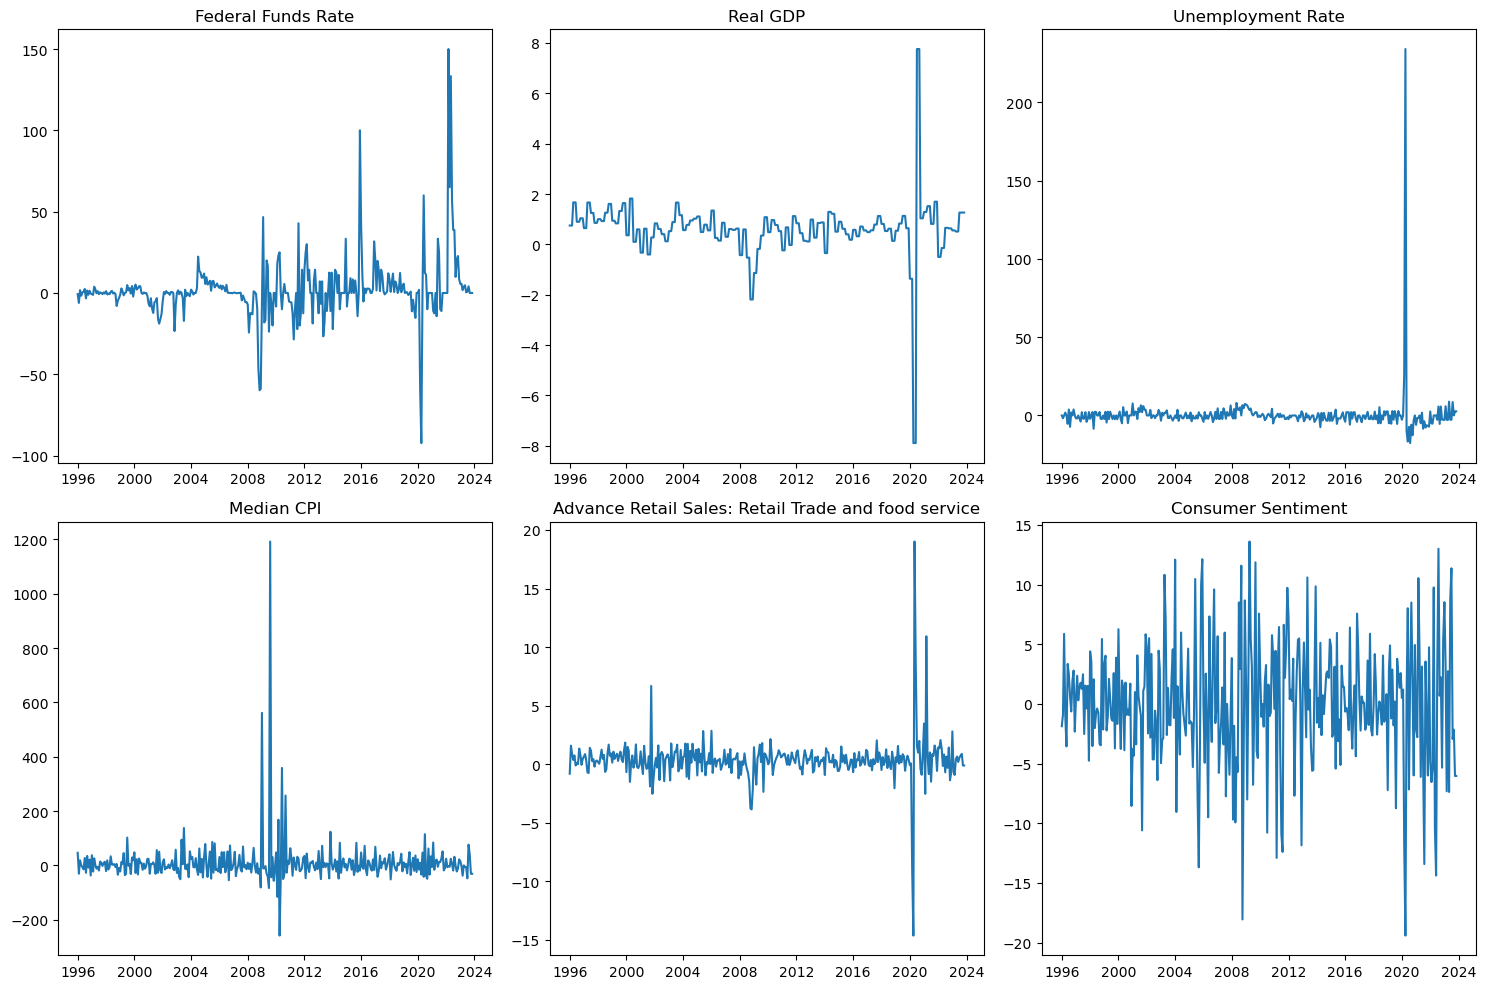

In [13]:
plot_data(percent_month.ffill())

**Understanding the data in isolation is insufficient; it's crucial to grasp the relationships among data points, particularly the way features evolve over time. To investigate how features change, we can examine if there's a difference in the pattern of change when considering monthly percentage changes versus annual percentage changes.**

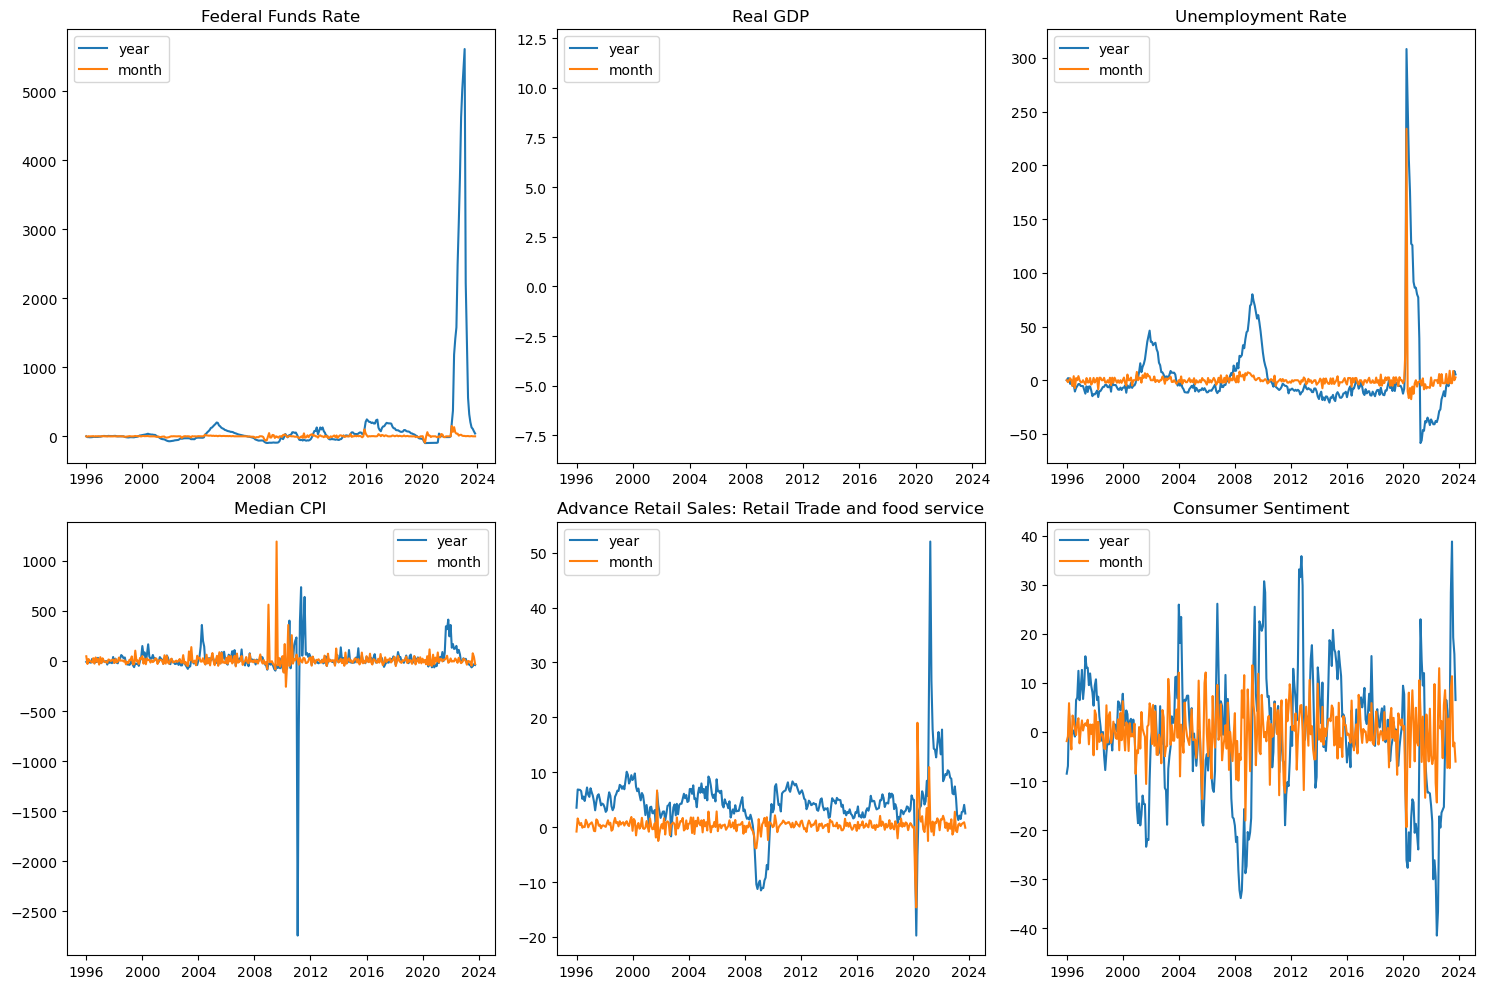

In [14]:
percent_year_month = percent_year.merge(percent_month, how = 'left', on = 'date', suffixes=('_year', '_month'))
percent_year_month.head()
# plot data by date, year and month in same subplot for each series_id
def plot_data_year_month(data):
    series_id_dict = {'FEDFUNDS': 'Federal Funds Rate',
                  'GDPC1': 'Real GDP', 
                  'UNRATE': 'Unemployment Rate',
                  'MEDCPIM158SFRBCLE': 'Median CPI', 
                  'RSAFS': 'Advance Retail Sales: Retail Trade and food service', 
                  'UMCSENT': 'Consumer Sentiment',
#                  'DPCCRV1Q225SBEA': 'PCE Excluding Food and Energy'
                  }
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    axs = axs.flatten()
    for ii, key in enumerate(series_id_dict.keys()):
        #print(ii, key)
        axs[ii].plot(data['date'], data[key + '_year'], label = 'year')
        axs[ii].plot(data['date'], data[key + '_month'], label = 'month')
        axs[ii].set_title(series_id_dict[key])
        axs[ii].legend()
    plt.tight_layout()
    plt.show()
plot_data_year_month(percent_year_month)

<Axes: >

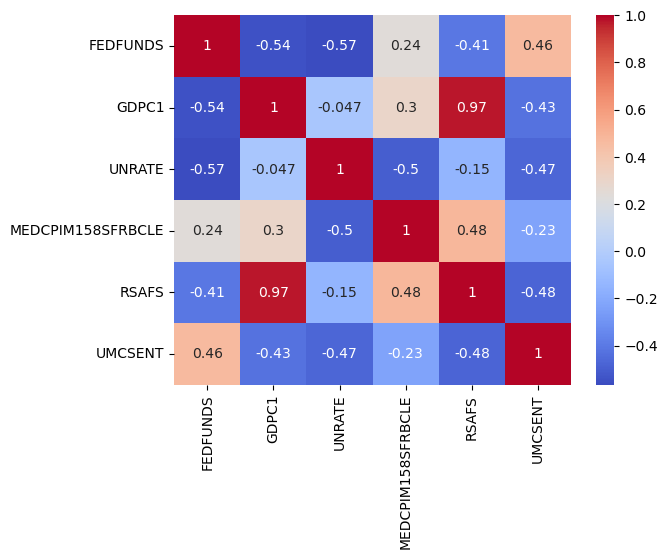

In [15]:
sns.heatmap(lin_data.iloc[:,1:].corr(), annot = True, cmap = 'coolwarm')

**From the graphs above, we can identify some relationship between variables. Thus, in the analysis, we may want to dig deeper.**

In [16]:
# ipynb ignore warinig
import warnings
warnings.filterwarnings('ignore')

**Since the effective rate data is not avaiblable from FRED, we use the data from the other source.**

In [17]:
FED_all = pd.read_excel('effective_rate.xlsx')

In [18]:
FED_all.head()

,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
0,11/27/2023,EFFR,5.33,5.3,5.32,5.33,5.5,97.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/24/2023,EFFR,5.33,5.3,5.32,5.33,5.5,101.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/2023,EFFR,5.33,5.3,5.32,5.33,5.5,102.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11/21/2023,EFFR,5.33,5.3,5.32,5.33,5.5,102.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/20/2023,EFFR,5.33,5.3,5.32,5.33,5.5,101.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Rename Columns
FED_use = FED_all[['Effective Date','Rate (%)', 'Target Rate From (%)','Target Rate To (%)']]
FED_use.rename(columns={'Effective Date': 'date','Rate (%)':'effective_rate','Target Rate From (%)' : 'target_lower','Target Rate To (%)':'target_upper'}, inplace=True)
FED_use['date'] = pd.to_datetime(FED_use['date'])

In [21]:
# Get potiential GDP
potential_GDP = get_FRED_data('GDPPOT')

In [22]:
# sort the FED_use by from 2000-01-01
FED_use = FED_use.sort_values(by = 'date')
FED_use = FED_use.reset_index(drop = True)
FED_use.head()

,date,effective_rate,target_lower,target_upper
0,2000-07-03,7.03,6.5,NaN
1,2000-07-05,6.52,6.5,NaN
2,2000-07-06,6.51,6.5,NaN
3,2000-07-07,6.42,6.5,NaN
4,2000-07-10,6.51,6.5,NaN


In [23]:
# merge all data
full_df = (pd.merge_asof(lin_data, FED_use, on='date', direction='nearest')
           .merge(percent_year_month, how = 'left', on = 'date')
           .merge(potential_GDP, how = 'left', on = 'date')
           )
full_df.head()

,date,FEDFUNDS,GDPC1,UNRATE,MEDCPIM158SFRBCLE,RSAFS,UMCSENT,effective_rate,target_lower,target_upper,...,MEDCPIM158SFRBCLE_year,RSAFS_year,UMCSENT_year,FEDFUNDS_month,GDPC1_month,UNRATE_month,MEDCPIM158SFRBCLE_month,RSAFS_month,UMCSENT_month,GDPPOT
0,1996-01-01,5.56,11614.418,5.6,3.775768,208699.0,89.3,7.03,6.5,NaN,...,-9.80430,3.53520,-8.50410,-0.71429,0.74905,0.00000,46.36763,-0.80799,-1.86813,10879.309158135062
1,1996-02-01,5.22,NaN,5.5,2.618961,212008.0,88.5,7.03,6.5,NaN,...,-21.53243,6.85941,-6.94006,-6.11511,NaN,-1.78571,-30.63766,1.58554,-0.89586,NaN
2,1996-03-01,5.31,NaN,5.5,3.110565,213891.0,93.7,7.03,6.5,NaN,...,-4.71751,6.81359,3.76523,1.72414,NaN,0.00000,18.77096,0.88817,5.87571,NaN
3,1996-04-01,5.22,11808.140,5.6,3.133276,214676.0,92.7,7.03,6.5,NaN,...,-14.35650,6.78698,0.21622,-1.69492,1.66794,1.81818,0.73012,0.36701,-1.06724,10961.169452731983
4,1996-05-01,5.24,NaN,5.6,2.937790,216299.0,89.4,7.03,6.5,NaN,...,-17.46535,6.55858,-0.44543,0.38314,NaN,0.00000,-6.23902,0.75602,-3.55987,NaN


In [24]:
# Add the health score to Unemployment Rate
import numpy as np
full_df['UNRATE_health'] = full_df['UNRATE'].apply(lambda x: -(np.exp(x/5)-2.7))
full_df[['UNRATE', 'UNRATE_health']].head()

,UNRATE,UNRATE_health
0,5.6,-0.364854
1,5.5,-0.304166
2,5.5,-0.304166
3,5.6,-0.364854
4,5.6,-0.364854


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


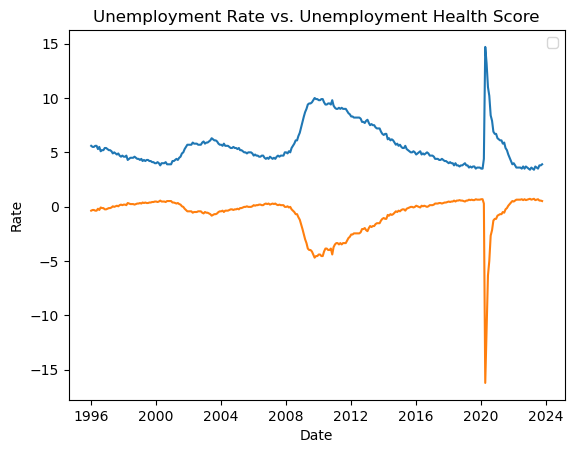

In [25]:
#plot unemployment rate and health score
sns.lineplot(x = 'date', y = 'UNRATE', data = full_df)
sns.lineplot(x = 'date', y = 'UNRATE_health', data = full_df)
plt.title('Unemployment Rate vs. Unemployment Health Score')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

**By exponentialize the unemployment data, we can see the trend more clearly**

In [27]:
# make the effective rate the first column
full_df.insert(1, 'effective_rate', full_df.pop('effective_rate'))
full_df.head()

,date,effective_rate,FEDFUNDS,GDPC1,UNRATE,MEDCPIM158SFRBCLE,RSAFS,UMCSENT,target_lower,target_upper,...,RSAFS_year,UMCSENT_year,FEDFUNDS_month,GDPC1_month,UNRATE_month,MEDCPIM158SFRBCLE_month,RSAFS_month,UMCSENT_month,GDPPOT,UNRATE_health
0,1996-01-01,7.03,5.56,11614.418,5.6,3.775768,208699.0,89.3,6.5,NaN,...,3.53520,-8.50410,-0.71429,0.74905,0.00000,46.36763,-0.80799,-1.86813,10879.309158135062,-0.364854
1,1996-02-01,7.03,5.22,NaN,5.5,2.618961,212008.0,88.5,6.5,NaN,...,6.85941,-6.94006,-6.11511,NaN,-1.78571,-30.63766,1.58554,-0.89586,NaN,-0.304166
2,1996-03-01,7.03,5.31,NaN,5.5,3.110565,213891.0,93.7,6.5,NaN,...,6.81359,3.76523,1.72414,NaN,0.00000,18.77096,0.88817,5.87571,NaN,-0.304166
3,1996-04-01,7.03,5.22,11808.140,5.6,3.133276,214676.0,92.7,6.5,NaN,...,6.78698,0.21622,-1.69492,1.66794,1.81818,0.73012,0.36701,-1.06724,10961.169452731983,-0.364854
4,1996-05-01,7.03,5.24,NaN,5.6,2.937790,216299.0,89.4,6.5,NaN,...,6.55858,-0.44543,0.38314,NaN,0.00000,-6.23902,0.75602,-3.55987,NaN,-0.364854


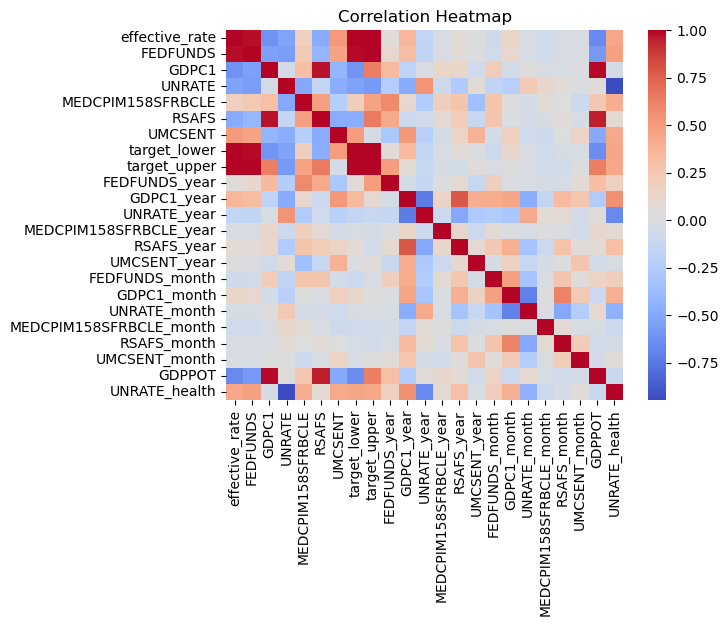

In [28]:
# heatmap of correlation
sns.heatmap(full_df.iloc[:,1:].corr(), annot = False, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [29]:
# save the full_df
full_df.to_csv('full_df.csv')

In [ ]:
# Get Target Data
statement = pd.read_csv('federal_reserve_statement_1999_2023.csv')
statement['date'] = pd.to_datetime(statement['date'], format='%Y%m%d')
statement.insert(0, 'date', statement.pop('date'))
statement.sort_values(by = 'date', inplace = True)
statement.head()

In [ ]:
FOMC_calendar = statement['date']
FOMC_3_day = FOMC_calendar + pd.Timedelta(days = 3)
FOMC_target = pd.DataFrame({'statement_day': FOMC_calendar, 'statement_3days': FOMC_3_day})
FOMC_target.head()

In [31]:
def get_FRED_daily(series_id, start_date = '1996-01-01', end_date = current_date, units = 'lin', fill_na = True):
    base_url = 'https://api.stlouisfed.org/fred/series/observations?'
    req = requests.get(
        base_url,
        params={
            'api_key': FRED_api,
            'series_id': series_id,
            'file_type': 'json',
            'observation_start': start_date,
            'observation_end': end_date,
            'units': units,
            'frequency': 'd'
        }
    )
    data = req.json()
    data = pd.DataFrame(data['observations'])
    data.drop(columns = 'realtime_start', inplace = True)
    data.drop(columns = 'realtime_end', inplace = True)
    data['date'] = pd.to_datetime(data['date'])
    data.rename(columns={'value': series_id}, inplace=True)
    #data.set_index('date', inplace = True)
    if fill_na:
        data[series_id].ffill(inplace = True)
    return data

In [32]:
DFF_daily = get_FRED_daily('DFF')
DFF_daily.head()

,date,DFF
0,1996-01-01,4.730
1,1996-01-02,6.060
2,1996-01-03,6.930
3,1996-01-04,5.690
4,1996-01-05,5.460


In [ ]:
# Get Final Target Data
# add the DFF_daily to FOMC_full by statement_day
FOMC_full = pd.merge_asof(FOMC_target, DFF_daily, left_on='statement_day', right_on='date', direction='nearest')
# add the DFF_daily to FOMC_full by statement_3days
FOMC_full = pd.merge_asof(FOMC_full, DFF_daily, left_on='statement_3days', right_on='date', direction='nearest')
# rename the columns
FOMC_full.rename(columns={'DFF_x': 'DFF_statement', 'DFF_y': 'DFF_3days'}, inplace=True)
# drop the date columns
FOMC_full.drop(columns = ['date_x', 'date_y'], inplace = True)
# change the date format
FOMC_full['DFF_statement'] = FOMC_full['DFF_statement'].astype(float)
FOMC_full['DFF_3days'] = FOMC_full['DFF_3days'].astype(float)
FOMC_full.head()
FOMC_full['difference'] = FOMC_full['DFF_3days'] - FOMC_full['DFF_statement']
FOMC_full['status'] = FOMC_full['difference'].apply(lambda x: '1' if x > 0.05 else '-1' if x < -0.05 else '0')
FOMC_full.head()

In [ ]:
FOMC_full['status'].value_counts().sort_index()

In [ ]:
FOMC_full['status'].value_counts().sort_index().plot(kind = 'bar', title='Target Rate Change')
plt.xticks(rotation=0)

In [ ]:
FOMC_full.to_csv('target_after_1999.csv')